In [ ]:
import numpy as np
import pandas as pd
!pip install esda
import esda
!pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import matplotlib.pyplot as plt
from shapely.geometry import Point

from re import sub
from decimal import Decimal

import json
from pathlib import Path

import plotly.express as px

     |████████████████████████████████| 112kB 36.3MB/s 
     |████████████████████████████████| 2.4MB 35.9MB/s 


/usr/local/lib/python3.7/dist-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


     |████████████████████████████████| 1.0MB 33.7MB/s 
     |████████████████████████████████| 15.4MB 188kB/s 
     |████████████████████████████████| 6.6MB 49.8MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /gdrive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: '/gdrive'
/content


In [ ]:
!pip install pysal -q
!pip install plotly==5.1.0 -q

     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 163kB 38.5MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 215kB 45.9MB/s 
     |████████████████████████████████| 5.7MB 49.9MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 143kB 53.9MB/s 
     |████████████████████████████████| 235kB 60.1MB/s 
     |████████████████████████████████| 245kB 59.6MB/s 
     |████████████████████████████████| 56.1MB 49kB/s 
     |████████████████████████████████| 2.0MB 34.4MB/s 
     |████████████████████████████████| 1.0MB 45.4MB/s 
     |████████████████████████████████| 19.3MB 1.2MB/s 
     |████████████████████████████████| 40.6MB 79kB/s 
     |████████████████████████████████| 133kB 61.0MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.

In [ ]:
!gdown --id 1ecgxSTxCmhCvVTSFgUBRGVjyGf3rLREW -O dataset.zip
!unzip dataset.zip


Downloading...
From: https://drive.google.com/uc?id=1ecgxSTxCmhCvVTSFgUBRGVjyGf3rLREW
To: /content/dataset.zip
69.1MB [00:01, 52.4MB/s]
Archive:  dataset.zip
  inflating: Datasets/econ_state.csv  
  inflating: Datasets/demographics.csv  
  inflating: Datasets/venues.csv.gz  
  inflating: Datasets/real_estate.csv.gz  
  inflating: Datasets/listings.csv   
  inflating: Datasets/calendar.csv.gz  


In [ ]:
!gzip -dk Datasets/*.gz

In [ ]:
# helper function to clean the dataset
def cleanPrice(df):
  def string2float(s):
    return Decimal(sub(r'[^\d.]', '', s))
  df['price']=df['price'].apply(string2float).astype(float)
  return df

In [ ]:
# helper function to get the median (mean) of each neighbourhood
def getMedian(df,gdf,key):
  median=df[key].groupby([df['neighbourhood']]).mean()
  gdf = gdf.join(median, on='neighbourhood')
  gdf.rename(columns={key: f'median_{key}'}, inplace=True)
  return gdf

In [ ]:
def plot_plotly(gdf,counties,key,dset,region):
  fig = px.choropleth(gdf,geojson=counties,locations='neighbourhood',
                    featureidkey='properties.neighbourhood',
                    color=key,
                          color_continuous_scale="Viridis",
                          scope="usa",
                          labels={key:key[7:]}
                          )
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.update_geos(fitbounds="locations")
  # fig.show()
  fname=f"./plotly/{dset}/{region}/{key[7:]}.html"
  fig.write_html(fname) # hardcoded to convert `median_XXX` to `XXX`
  print('Figure saved to ', fname)
  return fig

In [ ]:
def aggregateByNbhd(dset,region):
  df=pd.read_csv(f'./Datasets/{dset}.csv')
  try:
    df=cleanPrice(df)
  except:
    print("Cleaning skipped: Price not in dataframe")
  
  gdf = gpd.read_file(f'geoJson/{region}.geojson')

  region_gdf=constructGDF(df)
  sj_gdf = gpd.sjoin(gdf, region_gdf, how='inner', op='intersects', lsuffix='left', rsuffix='right')

  for k in sj_gdf.keys():
    try:
      gdf=getMedian(sj_gdf,gdf,k)
    except:
      print("Cannot get median of ", k)
  return gdf

def plotAndSave(gdf,dset,region):
  Path(f"./plotly/{dset}/{region}").mkdir(parents=True, exist_ok=True)
  counties = json.load(open(f'geoJson/{region}.geojson'))
  for key in gdf.keys():
    if 'median' in key:
      plot_plotly(gdf,counties,key,dset,region)

In [ ]:
listings = pd.read_csv("Datasets/listings.csv")

In [ ]:
listOfColumnsNeeded = ['accommodates', 'city', 'has_availability',
       'host_id', 'id', 'instant_bookable', 'latitude', 'longitude',
       'metropolitan', 'price', 'property_type',
       'review_scores_rating', 'room_type',
      'zipcode']

listings = listings[listOfColumnsNeeded]

In [ ]:
listings

,accommodates,city,has_availability,host_id,id,instant_bookable,latitude,longitude,metropolitan,price,property_type,review_scores_rating,room_type,zipcode
0,2.0,Asheville,NaN,2600734,665257,f,35.590784,-82.591466,asheville,$105.00,House,96.0,Entire home/apt,28806.0
1,4.0,Asheville,NaN,4295819,2746729,f,35.584968,-82.632199,asheville,$125.00,Tent,96.0,Entire home/apt,28806.0
2,1.0,Asheville,NaN,36223353,6919450,f,35.626600,-82.637618,asheville,$45.00,House,NaN,Private room,28806.0
3,6.0,Asheville,NaN,746673,12286328,f,35.579159,-82.596392,asheville,$24.00,Dorm,NaN,Shared room,28806.0
4,6.0,Asheville,NaN,746673,156926,f,35.577755,-82.594996,asheville,$24.00,House,93.0,Shared room,28806.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50316,2.0,la habra,NaN,107958524,18445825,t,33.930022,-117.974940,LA,$75.00,House,NaN,Private room,90631
50317,2.0,malibu,NaN,850039,18192212,f,34.037906,-118.654012,LA,$205.00,Apartment,NaN,Private room,90265
50318,10.0,malibu,NaN,117101757,17339165,f,34.036676,-118.650505,LA,$500.00,Villa,NaN,Entire home/apt,90265
50319,4.0,la habra,NaN,121899402,17827299,t,33.944261,-117.927134,LA,$65.00,House,NaN,Private room,90631


In [ ]:
groupByHostId = listings.groupby('host_id').count().sort_values('accommodates', ascending = False).iloc[:,:1]
groupByHostId = groupByHostId.rename(columns={'accommodates':'Multiple Listings'})

listings['Multiple Listings'] = listings['host_id'].map(groupByHostId.to_dict()['Multiple Listings'])

In [ ]:
listingsByMetro = {'Asheville': listings[listings['metropolitan'] == 'asheville'],
                  'Austin': listings[listings['metropolitan'] == 'austin'],
                  'Nashville': listings[listings['metropolitan'] == 'nashville'],
                  'New Orleans': listings[listings['metropolitan'] == 'new orleans'],
                  'Los Angeles': listings[listings['metropolitan'] == 'LA']
                  }

In [ ]:
hostByMetro = {}
for metro in listingsByMetro.keys():
  hostByMetro[metro] = listingsByMetro[metro].groupby('host_id').count().sort_values('accommodates', ascending = False).iloc[:,:1]
  hostByMetro[metro] = hostByMetro[metro].rename(columns={'accommodates':'Multiple Listings'})

  listingsByMetro[metro]['Multiple Listings'] = listingsByMetro[metro]['host_id'].map(hostByMetro[metro].to_dict()['Multiple Listings'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
for metro in listingsByMetro.keys():

  listingsByMetro[metro] = cleanPrice(listingsByMetro[metro])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
calendar = pd.read_csv("Datasets/calendar.csv")
calendar.head()

,listing_id,date,available,price,metro_area
0,665257,2016-04-22,f,NaN,asheville
1,665257,2016-04-23,f,NaN,asheville
2,665257,2016-04-24,f,NaN,asheville
3,665257,2016-04-25,f,NaN,asheville
4,665257,2016-04-26,f,NaN,asheville


In [ ]:
calendar.price = calendar.price.ffill()

In [ ]:
calendar = calendar.dropna()

calendar.available = calendar.available.map({'t': 0, 'f': -1})
calendar = cleanPrice(calendar)

In [ ]:
multipleListingsByPropertyId = listings[['id', 'Multiple Listings']]
multipleListingsByPropertyId.set_index('id', inplace=True)

calendar['Multiple Listings'] = calendar['listing_id'].map(multipleListingsByPropertyId.to_dict()['Multiple Listings'])

In [ ]:
calendar['Revenue'] = calendar.price * -(calendar.available) 
calendar.set_index('date', inplace=True)

In [ ]:
calendarSingleListing = calendar[calendar['Multiple Listings'] == 1]
calendarMultipleListing = calendar[calendar['Multiple Listings'] > 1]

In [ ]:

accommodatesByPropertyId = listings[['id', 'accommodates']]
accommodatesByPropertyId.set_index('id', inplace=True)

calendar['Accommodates'] = calendar['listing_id'].map(accommodatesByPropertyId.to_dict()['accommodates'])

In [ ]:
calendar['Price Per Night'] = calendar['price'] / calendar['Accommodates']
calendar.head()

,listing_id,available,price,metro_area,Multiple Listings,Revenue,Accommodates,Price Per Night
date,,,,,,,,
2016-05-31,665257,0,105.0,asheville,1.0,0.0,2.0,52.5
2016-06-01,665257,0,105.0,asheville,1.0,0.0,2.0,52.5
2016-06-02,665257,0,105.0,asheville,1.0,0.0,2.0,52.5
2016-06-03,665257,0,105.0,asheville,1.0,0.0,2.0,52.5
2016-06-04,665257,0,105.0,asheville,1.0,0.0,2.0,52.5


In [ ]:
propertyIdByZipcode = listings[['id', 'zipcode']]
propertyIdByZipcode.set_index('id', inplace=True)

calendar['zipcode'] = calendar['listing_id'].map(propertyIdByZipcode.to_dict()['zipcode'])

In [ ]:
medianPricePerZipcode = calendar.groupby(calendar['zipcode'])['Price Per Night'].median()

calendar['Median Price Per zipcode'] = calendar['zipcode'].map(medianPricePerZipcode.to_dict())

In [ ]:
groupByZipcode = listings.groupby('zipcode').count().sort_values('accommodates', ascending = False).iloc[:,:1]
groupByZipcode = groupByZipcode.rename(columns={'accommodates':'Volume by Zipcode'})

listings['Volume by Zipcode'] = listings['zipcode'].map(groupByZipcode.to_dict()['Volume by Zipcode'])
listings['Multiple Owner'] = listings['Multiple Listings'].apply(lambda x: 1 if x > 1 else 0)


In [ ]:
multipleOwnerByZipcode = round(listings.groupby('zipcode').mean()['Multiple Owner'])
listings['Multiple Owner by Zipcode'] = listings['zipcode'].map(multipleOwnerByZipcode.to_dict())

In [ ]:
listings

,accommodates,city,has_availability,host_id,id,instant_bookable,latitude,longitude,metropolitan,price,property_type,review_scores_rating,room_type,zipcode,Multiple Listings,Volume by Zipcode,Multiple Owner,Multiple Owner by Zipcode
0,2.0,Asheville,NaN,2600734,665257,f,35.590784,-82.591466,asheville,$105.00,House,96.0,Entire home/apt,28806.0,1,239.0,0,0.0
1,4.0,Asheville,NaN,4295819,2746729,f,35.584968,-82.632199,asheville,$125.00,Tent,96.0,Entire home/apt,28806.0,4,239.0,1,0.0
2,1.0,Asheville,NaN,36223353,6919450,f,35.626600,-82.637618,asheville,$45.00,House,NaN,Private room,28806.0,1,239.0,0,0.0
3,6.0,Asheville,NaN,746673,12286328,f,35.579159,-82.596392,asheville,$24.00,Dorm,NaN,Shared room,28806.0,6,239.0,1,0.0
4,6.0,Asheville,NaN,746673,156926,f,35.577755,-82.594996,asheville,$24.00,House,93.0,Shared room,28806.0,6,239.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50316,2.0,la habra,NaN,107958524,18445825,t,33.930022,-117.974940,LA,$75.00,House,NaN,Private room,90631,1,18.0,0,1.0
50317,2.0,malibu,NaN,850039,18192212,f,34.037906,-118.654012,LA,$205.00,Apartment,NaN,Private room,90265,2,425.0,1,1.0
50318,10.0,malibu,NaN,117101757,17339165,f,34.036676,-118.650505,LA,$500.00,Villa,NaN,Entire home/apt,90265,1,425.0,0,1.0
50319,4.0,la habra,NaN,121899402,17827299,t,33.944261,-117.927134,LA,$65.00,House,NaN,Private room,90631,1,18.0,0,1.0


In [ ]:
calendar = calendar[['metro_area', 'Revenue', 'zipcode', 'Median Price Per zipcode']]

In [ ]:
calendar = calendar.drop_duplicates('zipcode')

In [ ]:
temp = calendar.copy()
temp.index = pd.to_datetime(temp.index)
temp.reset_index(inplace=True)
zipCode = temp.pivot(index='zipcode', columns='date', values='Median Price Per zipcode').T.ffill().resample('M').asfreq().ffill().bfill().dropna(axis=1)

In [ ]:
zipCodePriceIn2016 = zipCode.iloc[0, :]
zipCodePriceIn2016 = pd.DataFrame(zipCodePriceIn2016)

volumeByZipcode = listings[['zipcode', 'Volume by Zipcode']]
volumeByZipcode.set_index('zipcode', inplace=True)

zipCodePriceIn2016['Volume By Zipcode'] = zipCodePriceIn2016.index.map(volumeByZipcode.to_dict()['Volume by Zipcode'])

multipleOwnerByZipcode = listings[['zipcode', 'Multiple Owner by Zipcode']]
multipleOwnerByZipcode.set_index('zipcode', inplace=True)

zipCodePriceIn2016['Multiple Owner by Zipcode'] = zipCodePriceIn2016.index.map(multipleOwnerByZipcode.to_dict()['Multiple Owner by Zipcode'])

zipCodePriceIn2016 = zipCodePriceIn2016.drop(['37216-2646', '90035-4475', '90005-3747',
'91604-3646','Near 91304'], axis=0)

zipCodePriceIn2016.index = zipCodePriceIn2016.index.astype(float)

zipCodePriceIn2016.columns = ['AirBnB Price', 'Volume By Zipcode', 'Multiple Owner by Zipcode']


In [ ]:
zipCodePriceIn2016

,AirBnB Price,Volume By Zipcode,Multiple Owner by Zipcode
zipcode,,,
210.0,16.500000,1.0,0.0
28704.0,28.750000,30.0,0.0
28715.0,25.000000,29.0,0.0
28732.0,32.500000,24.0,0.0
28759.0,23.333333,1.0,0.0
...,...,...,...
93550.0,23.750000,16.0,0.0
93552.0,13.000000,3.0,0.0
93591.0,29.687500,1.0,0.0


In [ ]:

import scipy

x = calendarMultipleListing.Revenue.groupby('date').mean()
y = calendarSingleListing.Revenue.groupby('date').mean()

scipy.stats.ttest_ind(x, y)

Ttest_indResult(statistic=-13.61745662875703, pvalue=5.803711974556123e-40)

In [ ]:
results = {}
for metro in listingsByMetro.keys():

  results[metro] = scipy.stats.ttest_ind(listingsByMetro[metro]['price'][listingsByMetro[metro]['Multiple Listings'] > 1], listingsByMetro[metro]['review_scores_rating'][listingsByMetro[metro]['Multiple Listings'] == 1], nan_policy='omit')

print(results)

{'Asheville': Ttest_indResult(statistic=3.6805470219189313, pvalue=0.00024887767038626174), 'Austin': Ttest_indResult(statistic=21.998173321583707, pvalue=1.1254745092164083e-103), 'Nashville': Ttest_indResult(statistic=22.27904703896894, pvalue=7.873587918521136e-102), 'New Orleans': Ttest_indResult(statistic=nan, pvalue=nan), 'Los Angeles': Ttest_indResult(statistic=20.27801727984052, pvalue=9.952829176314827e-91)}


In [ ]:
listingsByMetro['Asheville']['price'][listingsByMetro['Los Angeles']['Multiple Listings'] > 1].mean()

IndexingError: ignored

In [ ]:
listingsByMetro['Los Angeles']['price'][listingsByMetro['Los Angeles']['Multiple Listings'] == 1].mean()

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
zipcodes = calendar.zipcode[calendar.metro_area == 'LA'].tolist()
print(zipCodePriceIn2016)

          AirBnB Price  Volume By Zipcode  Multiple Owner by Zipcode
zipcode                                                             
210.0        16.500000                1.0                        0.0
28704.0      28.750000               30.0                        0.0
28715.0      25.000000               29.0                        0.0
28732.0      32.500000               24.0                        0.0
28759.0      23.333333                1.0                        0.0
...                ...                ...                        ...
93550.0      23.750000               16.0                        0.0
93552.0      13.000000                3.0                        0.0
93591.0      29.687500                1.0                        0.0
97202.0     350.000000                1.0                        0.0
999041.0     25.000000                1.0                        0.0

[195 rows x 3 columns]


In [ ]:
calendarData = {}

for metro in calendar.metro_area.unique():

  calendarData[metro] = calendar[calendar.metro_area == metro]



In [ ]:
def create_airbnb_data(calendarData):

  temp = calendarData.copy()
  temp.index = pd.to_datetime(temp.index)
  temp.reset_index(inplace=True)
  zipCode = temp.pivot(index='zipcode', columns='date', values='Median Price Per zipcode').T.ffill().resample('M').asfreq().ffill().bfill().dropna(axis=1)

  zipCodePriceIn2016 = zipCode.iloc[0, :]
  zipCodePriceIn2016 = pd.DataFrame(zipCodePriceIn2016)

  volumeByZipcode = listings[['zipcode', 'Volume by Zipcode']]
  volumeByZipcode.set_index('zipcode', inplace=True)

  zipCodePriceIn2016['Volume By Zipcode'] = zipCodePriceIn2016.index.map(volumeByZipcode.to_dict()['Volume by Zipcode'])

  multipleOwnerByZipcode = listings[['zipcode', 'Multiple Owner by Zipcode']]
  multipleOwnerByZipcode.set_index('zipcode', inplace=True)

  zipCodePriceIn2016['Multiple Owner by Zipcode'] = zipCodePriceIn2016.index.map(multipleOwnerByZipcode.to_dict()['Multiple Owner by Zipcode'])
  redundantZips = ['37216-2646', '90035-4475', '90005-3747',
    '91604-3646','Near 91304', '90005-3747']

  for zip in redundantZips:
    try:
      zipCodePriceIn2016 = zipCodePriceIn2016.drop([zip], axis=0)
    except: pass

  zipCodePriceIn2016.index = zipCodePriceIn2016.index.astype(float)

  zipCodePriceIn2016.columns = ['AirBnB Price', 'Volume By Zipcode', 'Multiple Owner by Zipcode']

  return zipCodePriceIn2016

In [ ]:
zipcodesData = {}

for metro in calendar.metro_area.unique():

  zipcodesData[metro] = create_airbnb_data(calendarData[metro])

NameError: ignored

,AirBnB Price,Volume By Zipcode,Multiple Owner by Zipcode
zipcode,,,
78644.0,50.000000,1.0,0.0
78652.0,13.500000,1.0,0.0
78702.0,50.500000,1202.0,0.0
78703.0,63.333333,642.0,0.0
78721.0,37.500000,191.0,0.0
78723.0,40.000000,335.0,0.0
78724.0,40.000000,53.0,0.0
78732.0,45.000000,39.0,0.0
78737.0,39.000000,55.0,0.0


In [ ]:
from linearmodels import PanelOLS

Make a monthly dataframe by the median price per person per zipcode in long format and then concat that with the ZHVI dataset in long format. Then do Pooled OLS where just do a simple regression and after test for significance of results and GM assumptions.

For panel data model, use long data only and use linearmodels as the main package

In [ ]:
rental = pd.read_csv(r"Datasets/real_estate.csv")
rental.head()

,type,zipcode,city,state,metro,county,size_rank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,ZHVI,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,886900,893400,888500,883000,887900,895100,901400,911100,915300,911400,908300,908600,904200,899400,901600,911500,926600,948100,970000,979800,983700,993700,1007800,1031000.0,1055800.0,1063500.0,1062900.0,1080800,1109400,1132500,1137500,1137700,1152700,1156000.0,1140200,1130000,1131900,1149600,1198400,1247000
1,ZHVI,60657,Chicago,IL,Chicago,Cook,2,146700.0,146500.0,146300.0,146300.0,146800.0,147100.0,147300.0,147800.0,148600.0,149100.0,149600.0,151100.0,153200.0,155100.0,157200.0,159100.0,160000.0,160800.0,162200.0,163200.0,164100.0,165600.0,167400.0,168000.0,168100.0,168500.0,168900.0,169100.0,170200.0,172100.0,174500.0,177100.0,180500.0,...,298800,298700,296700,296500,299700,303200,304700,305200,306800,309000,308800,306700,306600,308800,310200,310000,310400,310000,310300,311800,312500,311600,311800,313100.0,315000.0,317000.0,317500.0,317500,317900,318600,318200,318100,318800,320200.0,320800,322000,323800,326100,327800,329100
2,ZHVI,60614,Chicago,IL,Chicago,Cook,3,198000.0,195500.0,194200.0,193800.0,193900.0,194500.0,195900.0,197900.0,200100.0,199700.0,197700.0,197600.0,199700.0,200500.0,201000.0,202100.0,202700.0,202300.0,202500.0,203000.0,203200.0,203800.0,205200.0,206900.0,209100.0,210900.0,213700.0,217400.0,220600.0,222200.0,223300.0,224300.0,225900.0,...,361900,363900,365100,367200,370100,370900,368800,365200,364000,366900,368700,363600,357600,358000,359900,359300,359100,362000,368700,379500,386800,390300,393200,397200.0,400500.0,404000.0,403500.0,401400,400100,400700,401900,406000,414100,417800.0,417400,418400,414100,404100,406400,415500
3,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,70800.0,71000.0,71000.0,71400.0,71200.0,71600.0,72600.0,73100.0,72800.0,72800.0,72900.0,73100.0,73100.0,73300.0,73500.0,73900.0,74500.0,74900.0,75200.0,75400.0,75800.0,76200.0,76500.0,76700.0,76500.0,76400.0,76500.0,76300.0,76100.0,75900.0,75800.0,75800.0,75800.0,...,110600,110600,110800,111200,111500,111400,111300,111400,111500,111600,111700,111700,111600,111500,111500,111500,111700,111800,111800,111800,111500,111200,111200,111200.0,111200.0,111500.0,112000.0,112500,113200,113700,113800,113900,114100,114500.0,114900,115000,114700,114700,114800,114700
4,ZHVI,60640,Chicago,IL,Chicago,Cook,5,102300.0,101300.0,100700.0,100600.0,100700.0,101300.0,102300.0,103200.0,104400.0,105200.0,105600.0,106400.0,106800.0,106600.0,106900.0,107900.0,109100.0,109600.0,109000.0,108200.0,107900.0,107900.0,108000.0,108900.0,110900.0,112800.0,114100.0,115400.0,116400.0,117000.0,117800.0,119400.0,120800.0,...,183900,185200,186100,186100,186500,188900,191000,192400,193200,193400,192200,191600,192700,195700,197200,195700,193500,192600,193400,195200,195900,195900,196000,196000.0,195600.0,195800.0,195700.0,197500,199600,199900,198800,199200,200100,201500.0,203000,205100,206700,206500,206200,206700


In [ ]:
rentalZHVI = rental[rental.type == 'ZHVI']

In [ ]:
rental = rental[rental.type == 'ZRI']

In [ ]:
rentalZHVI[rentalZHVI.columns.difference(['metro', 'county','size_rank','state','city', 'type']).tolist()]

rental[rental.columns.difference(['metro', 'county','size_rank','state','city', 'type']).tolist()]

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,...,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,zipcode
13200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3395,3387,3377,3410,3444,3495,3539,3582,3587,3603,3626,3680,3750,3790,3832,3839,3855,3861,3862,3828,3798,3765,3754.0,3753.0,3783.0,3797.0,3799,3779,3750,3715,3681,3664,3674.0,3689,3696,3696,3691,3680,3669,10025
13201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2059,2068,2068,2072,2090,2111,2123,2124,2114,2105,2102,2111,2104,2104,2100,2102,2084,2067,2061,2057,2060,2079,2096.0,2105.0,2106.0,2108.0,2114,2110,2114,2117,2127,2122,2115.0,2105,2092,2078,2068,2071,2083,60657
13202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3557,3559,3570,3642,3697,3765,3855,3942,4026,4071,4133,4112,4110,4044,4096,4143,4183,4167,4112,4069,4020,3991,4012.0,4107.0,4199.0,4243.0,4184,4146,4071,4015,3965,3925,3902.0,3918,3920,3935,3932,3961,3983,10023
13203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2264,2306,2339,2397,2423,2453,2439,2399,2352,2334,2337,2382,2390,2394,2367,2355,2332,2318,2314,2312,2313,2320,2330.0,2344.0,2361.0,2364.0,2364,2355,2349,2345,2344,2351,2351.0,2354,2342,2324,2311,2308,2323,60614
13204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1031,1030,1026,1023,1020,1017,1014,1014,1019,1024,1031,1038,1044,1049,1054,1060,1063,1065,1067,1067,1064,1059,1048.0,1038.0,1028.0,1020.0,1016,1013,1014,1014,1013,1006,1000.0,998,1000,1001,1001,999,998,79936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1192,1194,1170,1155,1153,1165,1177,1183,1183,1171,1152,1133,1124,1117,1121,1136,1155,1170,1183,1192,1206,1226,1236.0,1234.0,1222.0,1212.0,1204,1201,1191,1185,1181,1174,1167.0,1156,1162,1175,1194,1202,1206,12720
29107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1605,1587,1568,1560,1570,1595,1615,1636,1644,1653,1668,1680,1705,1736,1754,1752,1731,1718,1708,1704,1700,1692,1701.0,1713.0,1735.0,1750.0,1767,1772,1774,1769,1772,1775,1780.0,1786,1790,1797,1798,1796,1795,1338
29108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3409,3408,3423,3439,3441,3444,3464,3506,3557,3593,3648,3679,3695,3672,3642,3628,3638,3671,3740,3843,3976,4108,4142.0,4139.0,4092.0,4091.0,4061,4063,4061,4048,4005,3888,3729.0,3563,3493,3474,3496

In [ ]:
rentalIn2016ZHVI = rentalZHVI[rentalZHVI.columns.difference(['metro', 'county','size_rank','state','city', 'type']).tolist()][['2016-04', 'zipcode']]
rentalIn2016ZHVI.set_index('zipcode', inplace=True)

rentalIn2016 = rental[rental.columns.difference(['metro', 'county','size_rank','state','city', 'type']).tolist()][['2016-04', 'zipcode']]
rentalIn2016.set_index('zipcode', inplace=True)

In [ ]:
rentalIn2016

,2016-04
zipcode,
10025,3783.0
60657,2106.0
10023,4199.0
60614,2361.0
79936,1028.0
...,...
12720,1222.0
1338,1735.0
21405,4092.0


In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [ ]:
rentalIn2016ZHVI.index = rentalIn2016ZHVI.index.astype(float)
rentalIn2016ZHVI.columns = ['ZHVI Home Value Index']

rentalIn2016.index = rentalIn2016.index.astype(float)
rentalIn2016.columns = ['ZRI Home Value Index']

In [ ]:
def regress(rentalIn2016, zipCodePriceIn2016):
  df = pd.concat([rentalIn2016, zipCodePriceIn2016], axis=1, join='inner')
  # df.columns = ['Home Value', 'Lag 1 Home Value', 'AirBnB Price', 'Volume By Zipcode', 'Multiple Owner by Zipcode']

  Y = np.log(df['ZHVI Home Value Index'])
  X = df[df.columns.difference(['ZHVI Home Value Index'])]
  # X['Lag 1 Home Value'] = np.log(X['Lag 1 Home Value'])
  X = sm.add_constant(X)

  result = sm.OLS(endog=Y, exog=X).fit(covariance_type='robust')
  print(result.summary())

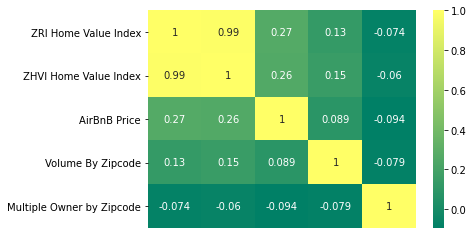

In [ ]:
# zipCodePriceIn2016 = zipCodePriceIn2016[zipCodePriceIn2016['Multiple Owner by Zipcode'] == 0]
import seaborn as sns
df = pd.concat([rentalIn2016, rentalIn2016ZHVI, zipCodePriceIn2016], axis=1, join='inner')
sns.heatmap(df.corr(), annot=True,cmap='summer', xticklabels=[])

In [ ]:
zipCodePriceIn2016 = create_airbnb_data(calendar)

In [ ]:
regress(rentalIn2016ZHVI, zipCodePriceIn2016)

                              OLS Regression Results                             
Dep. Variable:     ZHVI Home Value Index   R-squared:                       0.088
Model:                               OLS   Adj. R-squared:                  0.071
Method:                    Least Squares   F-statistic:                     5.332
Date:                   Sun, 18 Jul 2021   Prob (F-statistic):            0.00156
Time:                           15:02:16   Log-Likelihood:                -156.92
No. Observations:                    170   AIC:                             321.8
Df Residuals:                        166   BIC:                             334.4
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [ ]:
for metro in zipcodesData.keys():

  try:
    print("\n")
    print("------------------------------------------------------------")
    print("The Regression Report for Metropolitan Area: ", metro)
    
    regress(rentalIn2016, zipCodePriceIn2016=zipcodesData[metro])
    print("------------------------------------------------------------")

  except: pass



------------------------------------------------------------
The Regression Report for Metropolitan Area:  asheville
                            OLS Regression Results                            
Dep. Variable:             Home Value   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     3.516
Date:                Sun, 18 Jul 2021   Prob (F-statistic):              0.128
Time:                        07:24:04   Log-Likelihood:                 8.3119
No. Observations:                   8   AIC:                            -8.624
Df Residuals:                       4   BIC:                            -8.306
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.97

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning:

invalid value encountered in true_divide

